In [1]:
import numpy as np
import pandas as pd 
import shutil
import random
from PIL import Image, ImageOps
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import Dataset, Subset
from torchvision import transforms
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder
from math import *
import matplotlib.image as mpimg
import xml.etree.ElementTree as ET 
import cv2
from torchvision import transforms
import zipfile
import os
from tqdm import tqdm, trange

%matplotlib inline

## Основная часть:
1) Изучить литературу, разобраться в том, как работают системы распознавания лиц
2) Выбрать и скачать датасет
3) Обучить нейросеть для распознавания лиц (третий из трех этапов пайплайна) на лицах, которые уже детектированы и заалайнены;
4) Реализовать метрику качества ID rate, проверить точность распознавания сетей из пунктов 3 и 4
5) Поставить эксперименты с разными лосс-функциями
6) Сделать выводы

Дополнительная часть:
1) Изучить разные лосс-функции: ArcFace, TripletLoss и другие. Обучить сеть с их помощью
2) Обучить сеть для элайна фото лиц.
3) Обучить свою сеть для детекции лиц на фото, собрать весь пайплайн из сетей для детекции, элайна и распознавания;
4) Исследовать литературу по распознаванию лиц, сделать обзор современных улучшений. Реализовать их на выбор.
5) Исследовать распределение выученных эмбеддингов лиц

### Критерии:
    Основная часть — 6 баллов:
    Обучение нейросети для распознавания лиц — 2 балла;
    Реализация метрики ID rate — 2 балла;
    Эксперименты с лосс-функциями — 2 балла;

### Дополнительные части:
    1-2 балла каждое, в зависимости от сложности.

Максимум по проекту можно будет получить 10 баллов.  

In [2]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")


# Data loading

## Dataset for face Recognition task 

In [3]:
!kaggle datasets download -d atulanandjha/lfwpeople

Dataset URL: https://www.kaggle.com/datasets/atulanandjha/lfwpeople
License(s): GNU Lesser General Public License 3.0
... resuming from 17825792 bytes (225678096 bytes left) ...
 13%|█████▏                                 | 31.0M/232M [00:01<00:21, 9.81MB/s]^C
 14%|█████▌                                 | 33.0M/232M [00:02<00:26, 7.77MB/s]
User cancelled operation


In [ ]:
def extract_zip(zip_file_path, extract_to_dir):
    if not os.path.exists(extract_to_dir):
        os.makedirs(extract_to_dir)
    
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to_dir)

zip_file_path = 'lfwpeople.zip'
extract_to_dir = 'Images'
extract_zip(zip_file_path, extract_to_dir)

In [ ]:
import tarfile

def extract_tgz(tgz_file_path, extract_to_dir):
    if not os.path.exists(extract_to_dir):
        os.makedirs(extract_to_dir)
    
    with tarfile.open(tgz_file_path, "r:gz") as tar_ref:
        tar_ref.extractall(path=extract_to_dir)

tgz_file_path = 'Images/lfw-funneled.tgz'
extract_to_dir = 'Images'
extract_tgz(tgz_file_path, extract_to_dir)


## Train and Validation Datasets preparation

In [ ]:
# %%capture
# if not os.path.exists('/content/ibug_300W_large_face_landmark_dataset'):
#     !wget http://dlib.net/files/data/ibug_300W_large_face_landmark_dataset.tar.gz
#     !tar -xvzf 'ibug_300W_large_face_landmark_dataset.tar.gz'    
#     !rm -r 'ibug_300W_large_face_landmark_dataset.tar.gz'

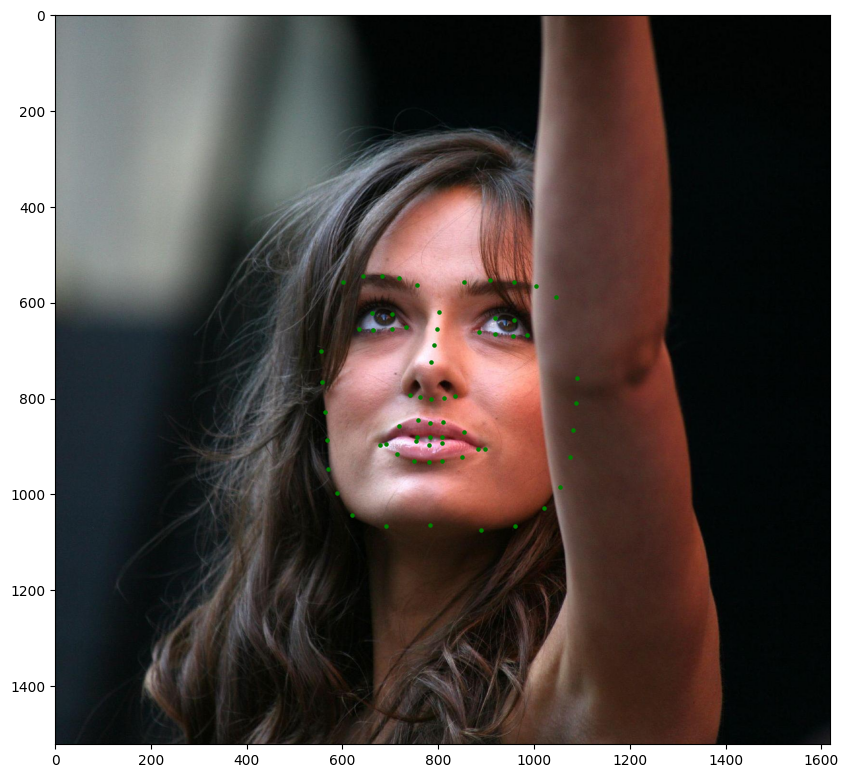

In [3]:
file = open('ibug_300W_large_face_landmark_dataset/helen/trainset/100032540_1.pts')
points = file.readlines()[3:-1]

landmarks = []

for point in points:
    x,y = point.split(' ')
    landmarks.append([floor(float(x)), floor(float(y[:-1]))])

landmarks = np.array(landmarks)

plt.figure(figsize=(10,10))
plt.imshow(mpimg.imread('ibug_300W_large_face_landmark_dataset/helen/trainset/100032540_1.jpg'))
plt.scatter(landmarks[:,0], landmarks[:,1], s = 5, c = 'g')
plt.show()

In [4]:
class Transforms():
    def __init__(self):
        pass
    
    def rotate(self, image, landmarks, angle):
        angle = torch.tensor(random.uniform(-angle, +angle))

        transformation_matrix = torch.tensor([
            [+cos(radians(angle.item())), -sin(radians(angle.item()))],
            [+sin(radians(angle.item())), +cos(radians(angle.item()))]
        ])

        image = transforms.functional.rotate(image, angle.item())

        landmarks = landmarks - 0.5
        new_landmarks = torch.matmul(landmarks, transformation_matrix)
        new_landmarks = new_landmarks + 0.5
        return image, new_landmarks


    def resize(self, image, landmarks, img_size):
        image = transforms.functional.resize(image, img_size)
        return image, landmarks

    def color_jitter(self, image, landmarks):
        color_jitter = transforms.ColorJitter(brightness=0.3, 
                                              contrast=0.3,
                                              saturation=0.3, 
                                              hue=0.1)
        image = color_jitter(image)
        return image, landmarks

    def crop_face(self, image, landmarks, crops):
        left = int(crops['left'])
        top = int(crops['top'])
        width = int(crops['width'])
        height = int(crops['height'])

        image = transforms.functional.crop(image, top, left, height, width)

        img_shape = np.array(image).shape
        landmarks = torch.tensor(landmarks) - torch.tensor([[left, top]])
        landmarks = landmarks / torch.tensor([img_shape[1], img_shape[0]])
        return image, landmarks

    def __call__(self, image, landmarks, crops):
        image = Image.fromarray(image)
        image, landmarks = self.crop_face(image, landmarks, crops)
        image, landmarks = self.resize(image, landmarks, (224, 224))
        image, landmarks = self.color_jitter(image, landmarks)
        image, landmarks = self.rotate(image, landmarks, angle=10)
        
        image = transforms.functional.to_tensor(image)
        image = transforms.functional.normalize(image, [0.5], [0.5])
        return image, landmarks

In [5]:
class FaceLandmarksDataset(Dataset):

    def __init__(self, transform=None):

        tree = ET.parse('ibug_300W_large_face_landmark_dataset/labels_ibug_300W_train.xml')
        root = tree.getroot()

        self.image_filenames = []
        self.landmarks = []
        self.crops = []
        self.transform = transform
        self.root_dir = 'ibug_300W_large_face_landmark_dataset'
        
        for filename in root[2]:
            self.image_filenames.append(os.path.join(self.root_dir, filename.attrib['file']))

            self.crops.append(filename[0].attrib)

            landmark = []
            for num in range(68):
                x_coordinate = int(filename[0][num].attrib['x'])
                y_coordinate = int(filename[0][num].attrib['y'])
                landmark.append([x_coordinate, y_coordinate])
            self.landmarks.append(landmark)

        self.landmarks = np.array(self.landmarks).astype('float32')     

        assert len(self.image_filenames) == len(self.landmarks)

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, index):
        image = cv2.imread(self.image_filenames[index], 0)
        landmarks = self.landmarks[index]
        crops = self.crops[index]
    
        if self.transform:
            image, landmarks = self.transform(image, landmarks, crops)
    
        landmarks = landmarks - 0.5

        return image, landmarks

dataset = FaceLandmarksDataset(Transforms())

In [6]:
from torch.utils.data import DataLoader, random_split

val_size = int(0.1 * len(dataset))  
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])

batch_size = 16
if device == torch.device("cuda"):
    train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_ds, batch_size, num_workers=4)
else:
    train_loader = DataLoader(train_ds, batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size)

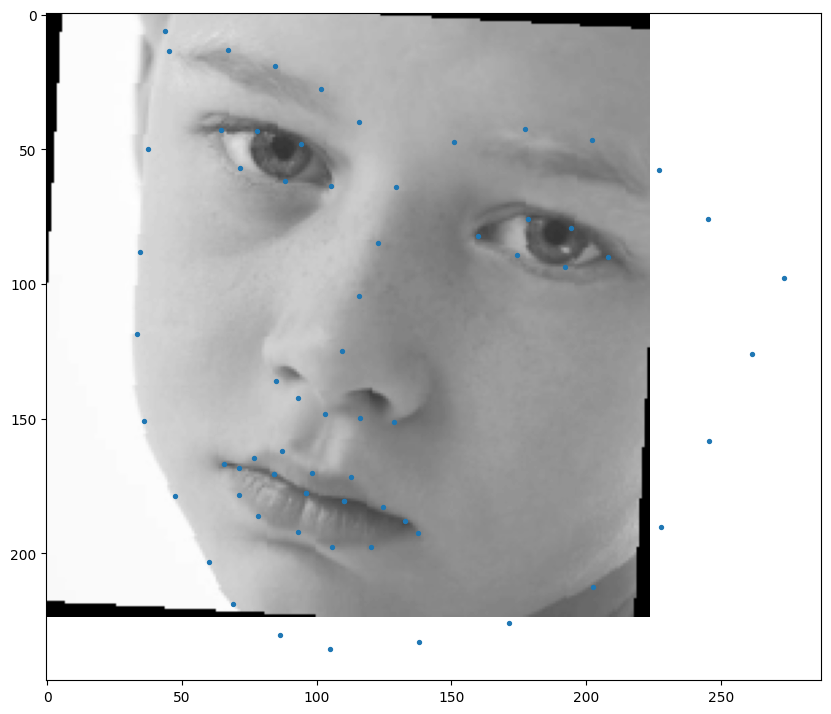

In [7]:
image, landmarks = dataset[1]
def visualize_landmarks(image, landmarks):
    landmarks = (landmarks + 0.5) * 224
    plt.figure(figsize=(10, 10))
    plt.imshow(image.numpy().squeeze(), cmap='gray');
    plt.scatter(landmarks[:,0], landmarks[:,1], s=8);
    plt.show()
    
visualize_landmarks(image, landmarks)

## Test datasets preparation

### Exclude people with less than 2 images

In [8]:
class FaceRecognitionDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = os.listdir(root_dir)
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        self.images = []
        for class_ in self.classes:
            class_dir = os.path.join(root_dir, class_)
            if os.path.isdir(class_dir):
                class_images = [os.path.join(class_dir, img) for img in os.listdir(class_dir)]
                if len(class_images) >= 2:  # Only add the class if it has two or more images
                    self.images.extend([(img_path, class_) for img_path in class_images])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path, label = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        label = self.class_to_idx[label]
        return image, label

    def get_class_to_idx(self):
        return self.class_to_idx

    def get_path(self, idx):
        return self.images[idx][0]


In [9]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=1), 
    transforms.ToTensor(),
])
dir_for_face_recognition = 'Images/lfw_funneled'
test_dataset = FaceRecognitionDataset(dir_for_face_recognition, transform=transform)

In [10]:
batch_size = 16
if device == torch.device("cuda"):
    test_loader = DataLoader(test_dataset, batch_size, num_workers=4)
else:
    test_loader = DataLoader(test_dataset, batch_size)

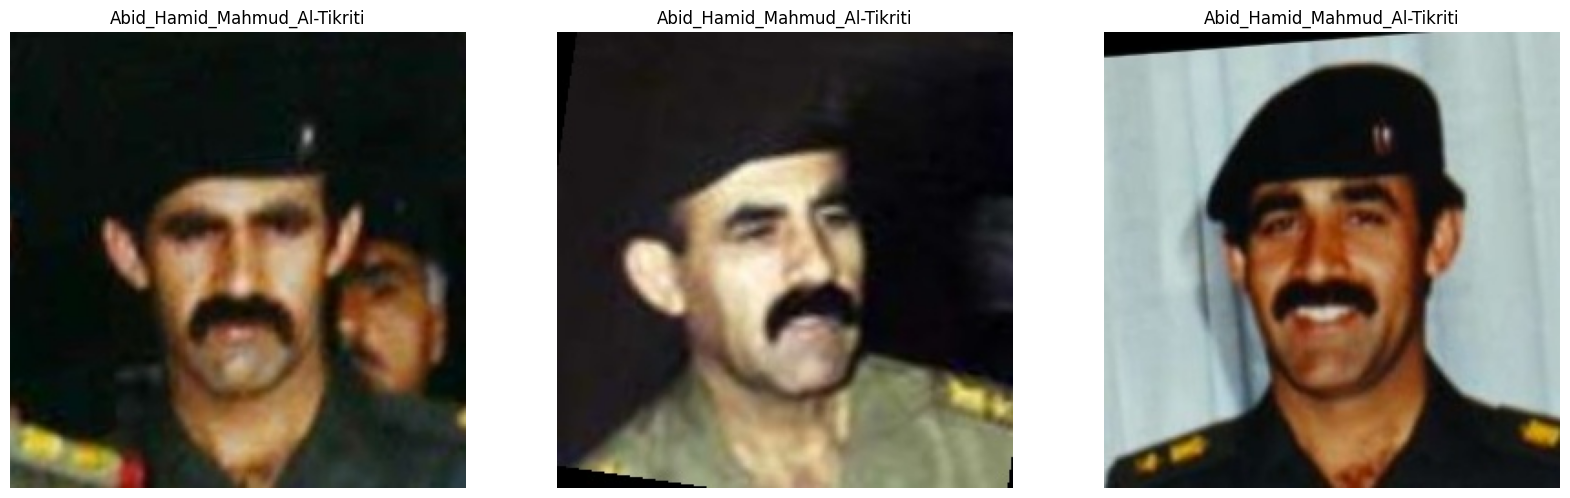

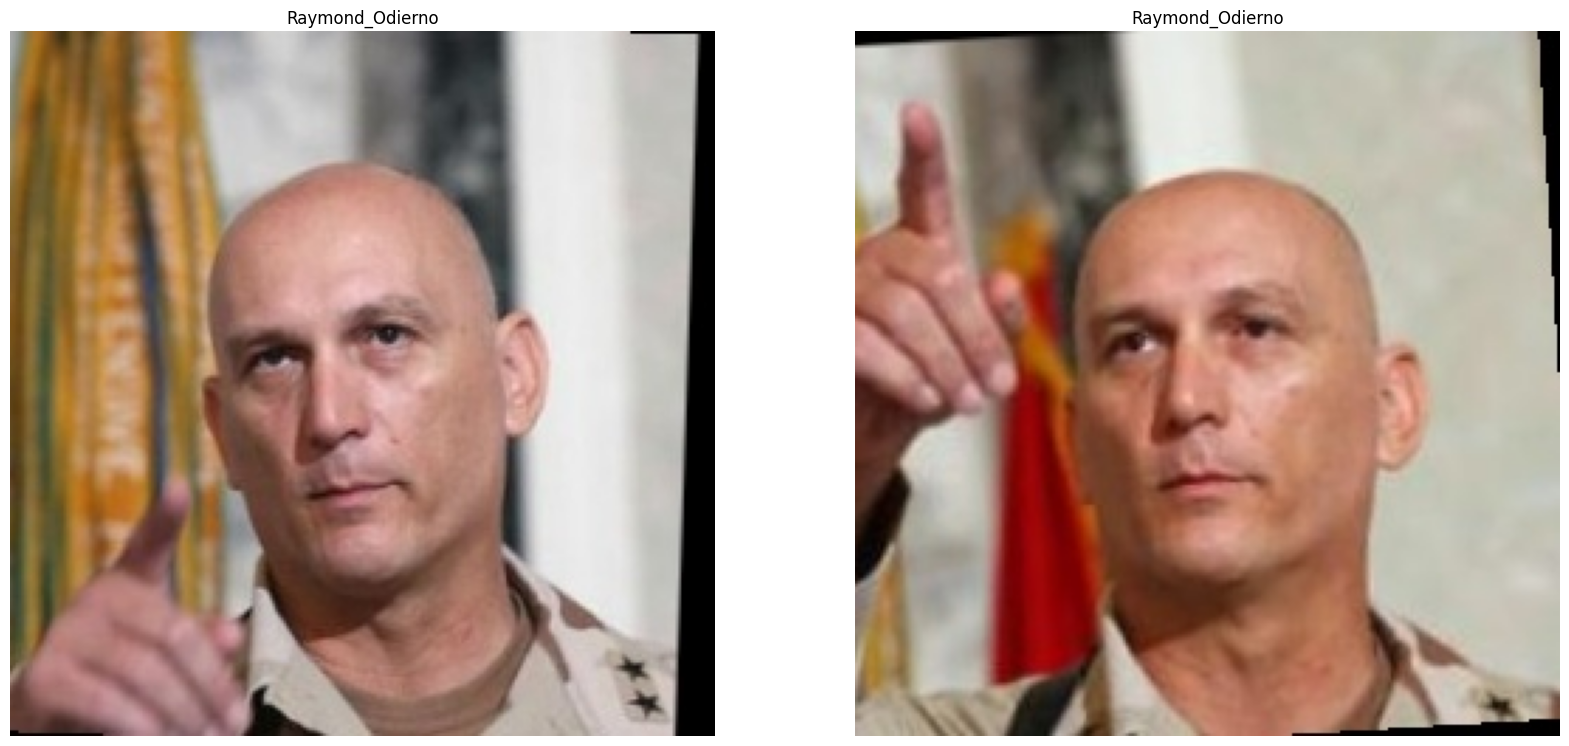

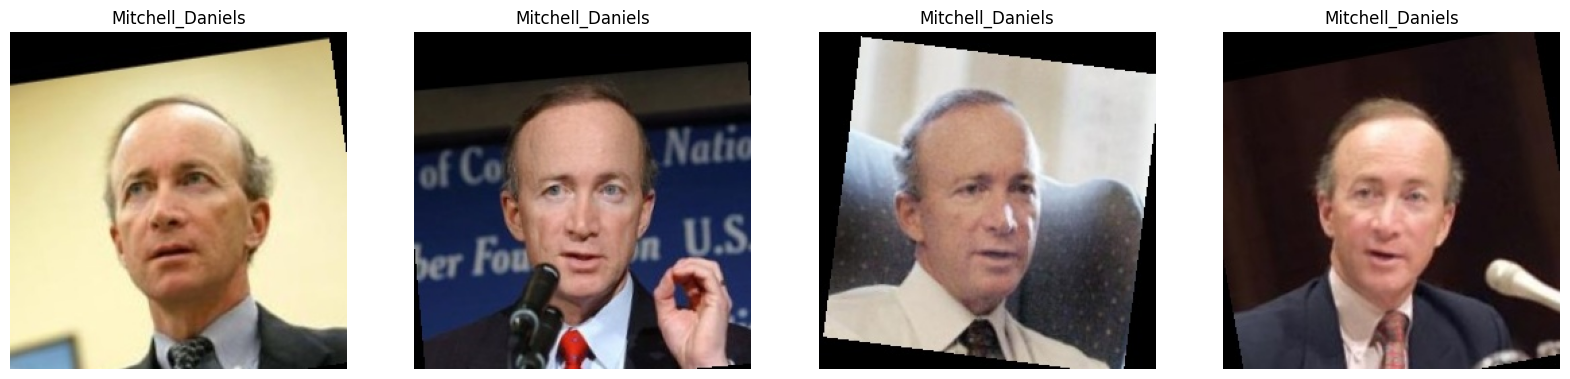

In [11]:
def visualize_images(dataset, num_people=3):
    unique_classes = list(set([label for _, label in dataset.images]))

    selected_classes = unique_classes[:num_people]

    for person in selected_classes:
        images = [img for img, label in dataset.images if label == person]

        if len(images) == 1:
            fig, ax = plt.subplots(figsize=(5, 5))
            ax.imshow(Image.open(images[0]))
            ax.axis('off')
            ax.set_title(person)  
        else:
            fig, axs = plt.subplots(1, len(images), figsize=(20, 20))

            # Display each image
            for i, image in enumerate(images):
                axs[i].imshow(Image.open(image))
                axs[i].axis('off')
                axs[i].set_title(person) 

        plt.show()

visualize_images(test_dataset)

## Face detection model

##### We will use MTCNN for face detection, because it is optimal in terms of the rate of inference and quality, and often in the spread of faces, speed is an important factor. It is also desirable to allocate more time for alignment, since it can perform well even with low-quality detection
        It was also possible to use RetinaFace + DeepFace lib, this is almost the SOTA in general 
        and almost all tasks could be done on it, but there is no special interest 
        in this, but the whole implementation through this lib will be for quality comparison. 

In [12]:
# !pip install facenet-pytorch 
from facenet_pytorch import MTCNN
new_root_dir = 'Detected_faces'


In [37]:
os.makedirs(new_root_dir, exist_ok=True)

for class_ in test_dataset.classes:
    class_dir = os.path.join(new_root_dir, class_)
    os.makedirs(class_dir, exist_ok=True)
    

In [38]:
from torchvision.utils import save_image
def crop_and_resize(img, box, size=(224, 224)):
    face = img.crop((box[0], box[1], box[2], box[3]))
    face = ImageOps.fit(face, size, method=Image.BICUBIC, bleed=0.0, centering=(0.5, 0.5))
    return face

mtcnn = MTCNN(image_size=224, margin=0, post_process=True)

for i, (img, label) in tqdm(enumerate(test_dataset)):
    img_path = test_dataset.get_path(i)
    temp_image = Image.open(img_path).convert('RGB')
    boxes, probs = mtcnn.detect(temp_image)    
    if boxes is not None and len(boxes) > 0:
        face = crop_and_resize(temp_image, boxes[0])
        new_img_path = img_path.replace(dir_for_face_recognition, new_root_dir)
        new_img_dir = os.path.dirname(new_img_path)
        os.makedirs(new_img_dir, exist_ok=True)
        face.save(new_img_path)
    else:
        print(f"Face not detected in image: {img_path}")

9164it [04:09, 36.66it/s]


In [39]:
for root, dirs, files in os.walk(new_root_dir, topdown=False):
    for dir_ in dirs:
        dir_path = os.path.join(root, dir_)
        if not os.listdir(dir_path):
            os.rmdir(dir_path)

In [13]:
detected_test_dataset = FaceRecognitionDataset(new_root_dir, transform=transform)
batch_size = 16
if device == torch.device("cuda"):
    detected_test_loader = DataLoader(detected_test_dataset, batch_size, num_workers=4)
else:
    detected_test_loader = DataLoader(detected_test_dataset, batch_size)


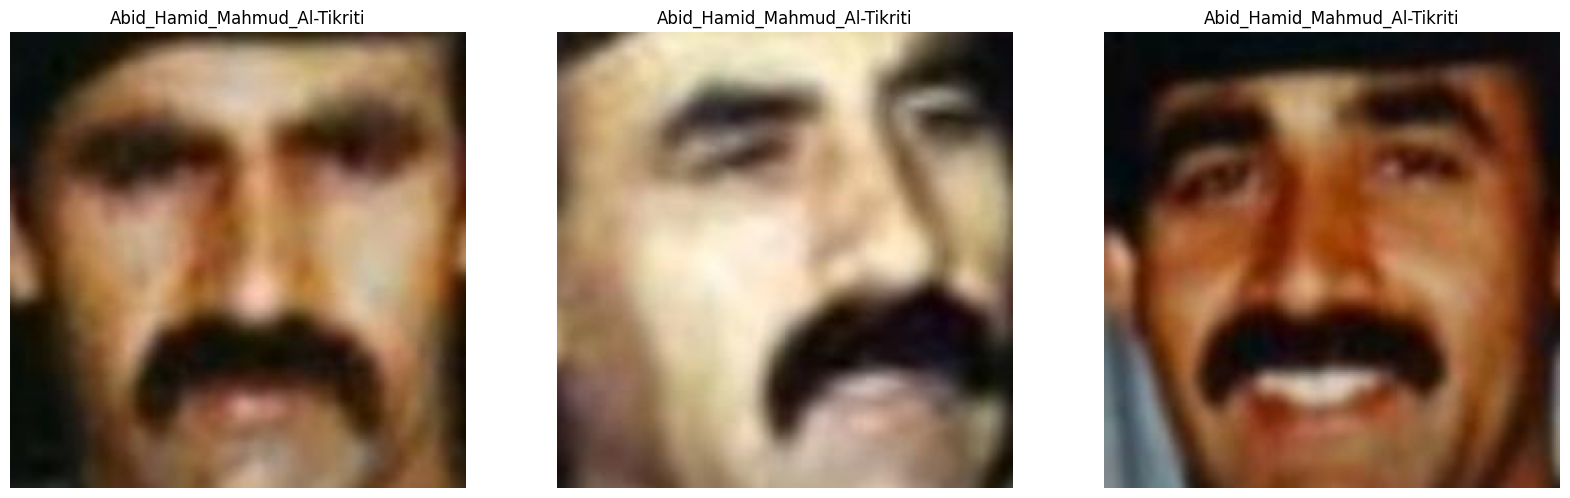

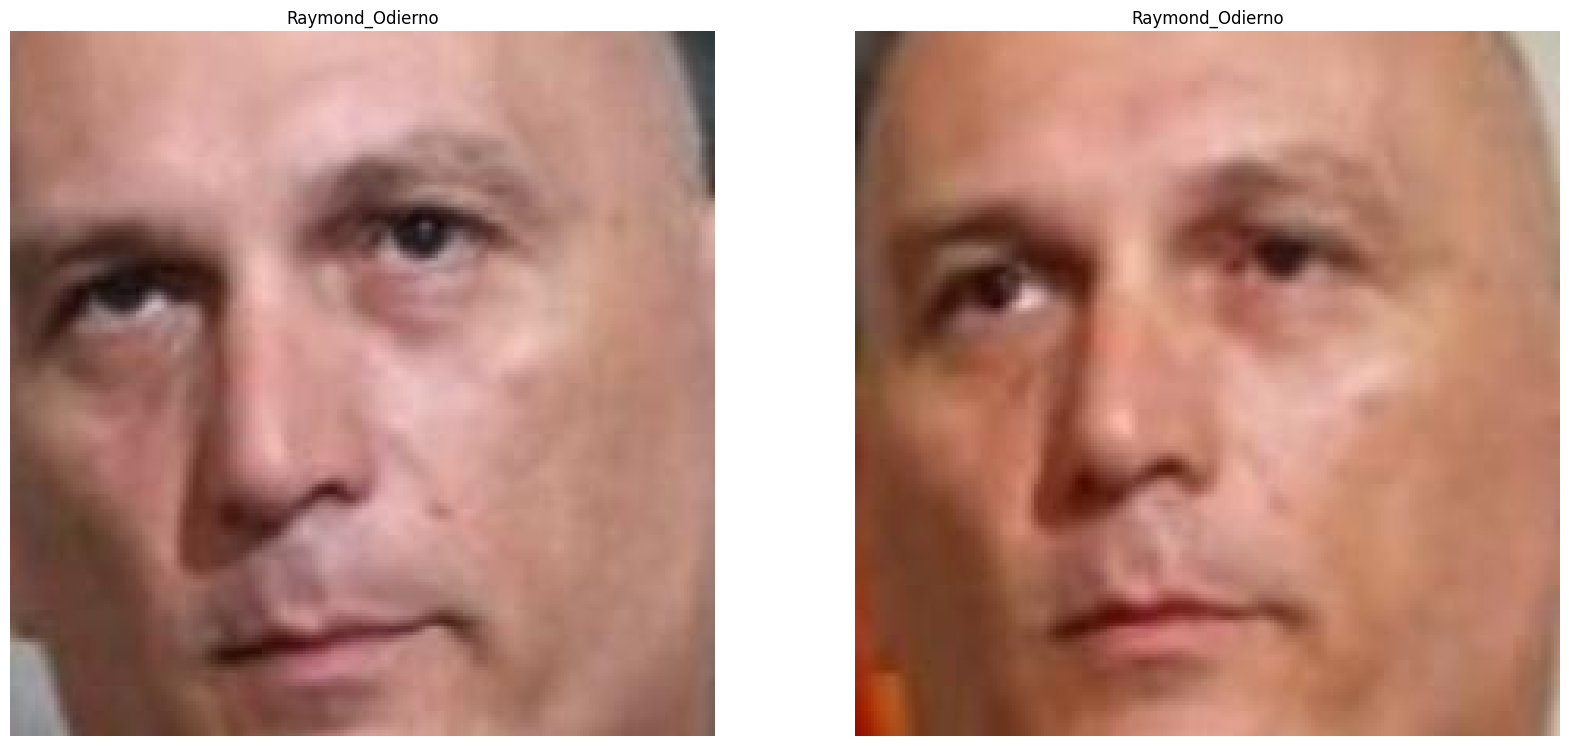

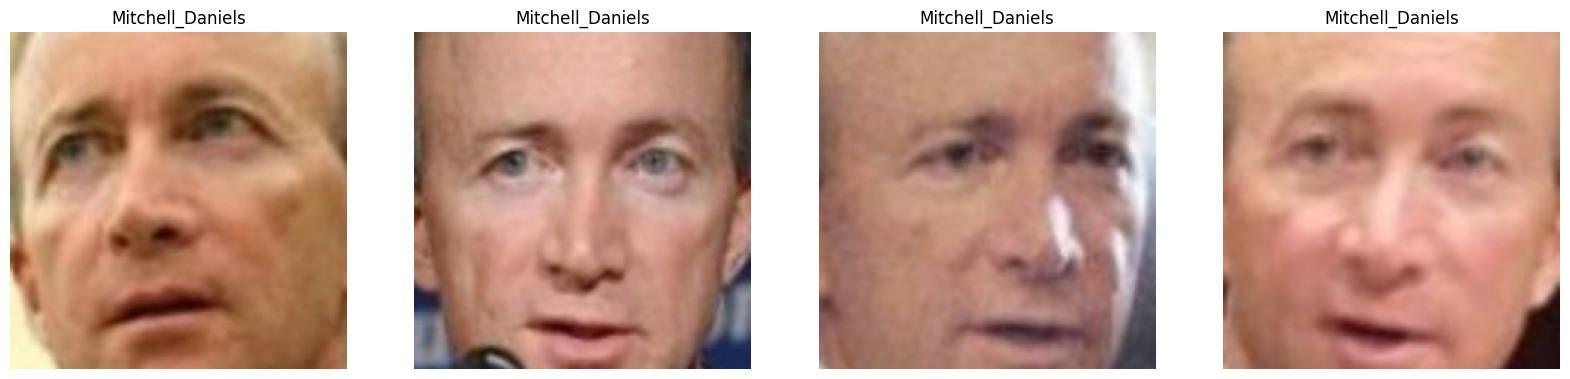

In [14]:
visualize_images(detected_test_dataset)

## Alignment models

### Handmade model

In [15]:
class DepthewiseSeperableConv2d(nn.Module):
    def __init__(self, input_channels, output_channels, kernel_size, **kwargs):
        super(DepthewiseSeperableConv2d, self).__init__()

        self.depthwise = nn.Conv2d(input_channels, input_channels, kernel_size, groups = input_channels, bias = False, **kwargs)
        self.pointwise = nn.Conv2d(input_channels, output_channels, 1, bias = False)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)

        return x

In [16]:
class EntryBlock(nn.Module):
    def __init__(self):
        super(EntryBlock, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding = 1, bias = False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding = 1, bias = False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2)
        )

        self.conv3_residual = nn.Sequential(
            DepthewiseSeperableConv2d(64, 64, 3, padding = 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            DepthewiseSeperableConv2d(64, 128, 3, padding = 1),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(3, stride = 2, padding = 1),
        )

        self.conv3_direct = nn.Sequential(
            nn.Conv2d(64, 128, 1, stride = 2),
            nn.BatchNorm2d(128),
        )

        self.conv4_residual = nn.Sequential(
            nn.LeakyReLU(0.2),
            DepthewiseSeperableConv2d(128, 128, 3, padding = 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            DepthewiseSeperableConv2d(128, 256, 3, padding = 1),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(3, stride = 2, padding = 1)
        )

        self.conv4_direct = nn.Sequential(
            nn.Conv2d(128, 256, 1, stride = 2),
            nn.BatchNorm2d(256),
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)

        residual = self.conv3_residual(x)
        direct = self.conv3_direct(x)
        x = residual + direct
        
        residual = self.conv4_residual(x)
        direct = self.conv4_direct(x)
        x = residual + direct

        return x

In [17]:
class MiddleBasicBlock(nn.Module):
    def __init__(self):
        super(MiddleBasicBlock, self).__init__()

        self.conv1 = nn.Sequential(
            nn.LeakyReLU(0.2),
            DepthewiseSeperableConv2d(256, 256, 3, padding = 1),
            nn.BatchNorm2d(256)
        )
        self.conv2 = nn.Sequential(
            nn.LeakyReLU(0.2),
            DepthewiseSeperableConv2d(256, 256, 3, padding = 1),
            nn.BatchNorm2d(256)
        )
        self.conv3 = nn.Sequential(
            nn.LeakyReLU(0.2),
            DepthewiseSeperableConv2d(256, 256, 3, padding = 1),
            nn.BatchNorm2d(256)
        )

    def forward(self, x):
        residual = self.conv1(x)
        residual = self.conv2(residual)
        residual = self.conv3(residual)

        return x + residual


class MiddleBlock(nn.Module):
    def __init__(self, num_blocks):
        super().__init__()

        self.block = nn.Sequential(*[MiddleBasicBlock() for _ in range(num_blocks)])

    def forward(self, x):
        x = self.block(x)

        return x

In [18]:
class ExitBlock(nn.Module):
    def __init__(self):
        super(ExitBlock, self).__init__()

        self.residual = nn.Sequential(
            nn.LeakyReLU(0.2),
            DepthewiseSeperableConv2d(256, 256, 3, padding = 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            DepthewiseSeperableConv2d(256, 512, 3, padding = 1),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(3, stride = 2, padding = 1)
        )

        self.direct = nn.Sequential(
            nn.Conv2d(256, 512, 1, stride = 2),
            nn.BatchNorm2d(512)
        )

        self.conv = nn.Sequential(
            DepthewiseSeperableConv2d(512, 512, 3, padding = 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            DepthewiseSeperableConv2d(512, 1024, 3, padding = 1),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2)
        )

        self.dropout = nn.Dropout(0.3)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

    def forward(self, x):
        direct = self.direct(x)
        residual = self.residual(x)
        x = direct + residual
        
        x = self.conv(x)
        x = self.avgpool(x)
        x = self.dropout(x)

        return x
     


In [21]:
class XceptionNet(nn.Module):
    def __init__(self, num_middle_blocks = 6):
        super(XceptionNet, self).__init__()

        self.entry_block = EntryBlock()
        self.middel_block = MiddleBlock(num_middle_blocks)
        self.exit_block = ExitBlock()

        self.fc = nn.Linear(1024, 136)

    def forward(self, x):
        x = self.entry_block(x)
        x = self.middel_block(x)
        x = self.exit_block(x)

        x = x.view(x.size(0), -1)
        
        x = self.fc(x)

        return x

In [22]:
model_XceptionNet = XceptionNet()

## Training

### XceptionNet

In [24]:
model_XceptionNet.to(device)

objective = nn.MSELoss()
optimizer = optim.AdamW(model_XceptionNet.parameters(), lr = 0.0008)

In [61]:
@torch.no_grad()
def validate(save = None):
    model_XceptionNet.eval()
    cum_loss = 0.0

    for features, labels in tqdm(val_loader, desc = 'Validating', ncols = 600):
        features = features.to(device)
        labels = labels.to(device)
        labels = labels.view(labels.size(0), -1)

        outputs = model_XceptionNet(features)        

        loss = objective(outputs, labels)

        cum_loss += loss.item()
    visualize_landmarks(features[:1].cpu(), outputs[:1].cpu().reshape((68, 2)))

    return cum_loss/len(val_loader)




#### Before training

Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:12<00:00,  1.71it/s]


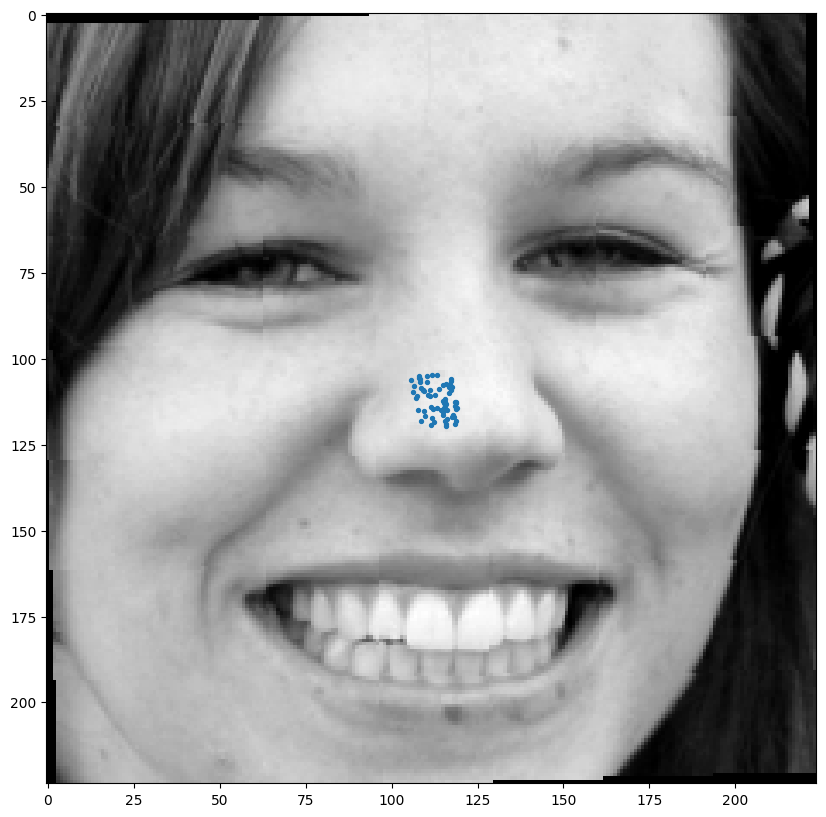

0.06802014935584295

In [25]:
validate()

In [ ]:
if os.path.isdir('progress'):
    !rm -rf progress
os.mkdir('progress')
     

In [ ]:
epochs = 30
batches = len(train_loader)
best_loss = np.inf
optimizer.zero_grad()

for epoch in range(epochs):
    cum_loss = 0.0

    model_XceptionNet.train()
    for batch_index, (features, labels) in enumerate(tqdm(train_loader, desc = f'Epoch({epoch + 1}/{epochs})', ncols = 800)):
        features = features.to(device) 
        labels = labels.to(device)
        labels = labels.view(labels.size(0), -1)

        outputs = model_XceptionNet(features)
        
        loss = objective(outputs, labels)

        loss.backward()

        optimizer.step()
        
        optimizer.zero_grad()

        cum_loss += loss.item()

        torch.cuda.empty_cache()  

    val_loss = validate(os.path.join('progress', f'epoch({str(epoch + 1).zfill(len(str(epochs)))}).jpg'))

    if val_loss < best_loss:
        best_loss = val_loss
        print('Saving model....................')
        torch.save(model_XceptionNet.state_dict(), 'model_XceptionNet.pt')

    print(f'Epoch({epoch + 1}/{epochs}) -> Training Loss: {cum_loss/batches:.8f} | Validation Loss: {val_loss:.8f}')

In [23]:
model_XceptionNet.load_state_dict(torch.load('model_XceptionNet.pt', map_location = 'cpu'))

<All keys matched successfully>

#### After training

Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:17<00:00,  1.18it/s]


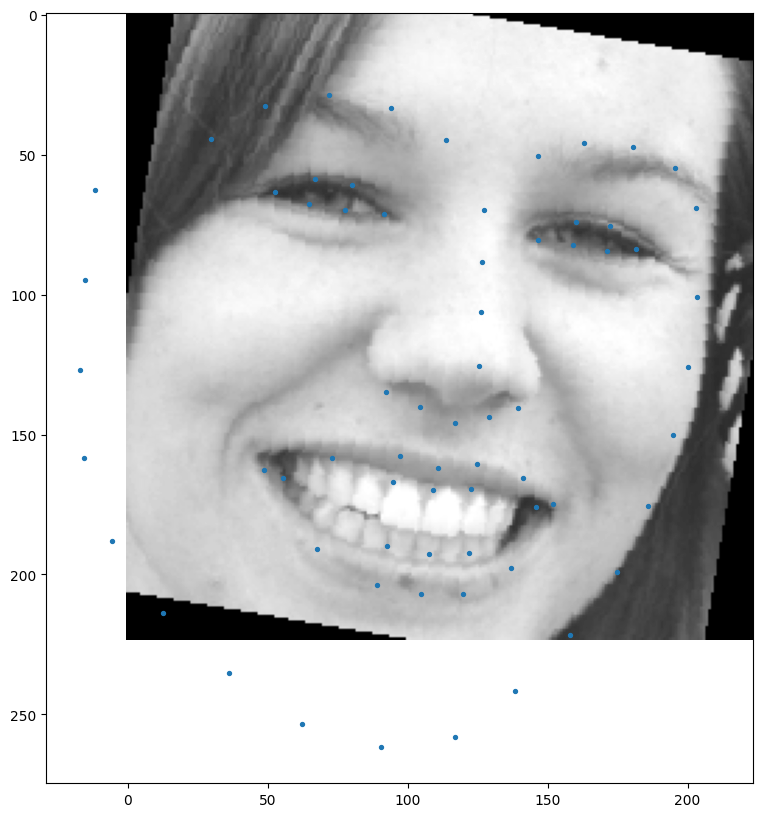

0.0005746516731700727

In [62]:
validate()

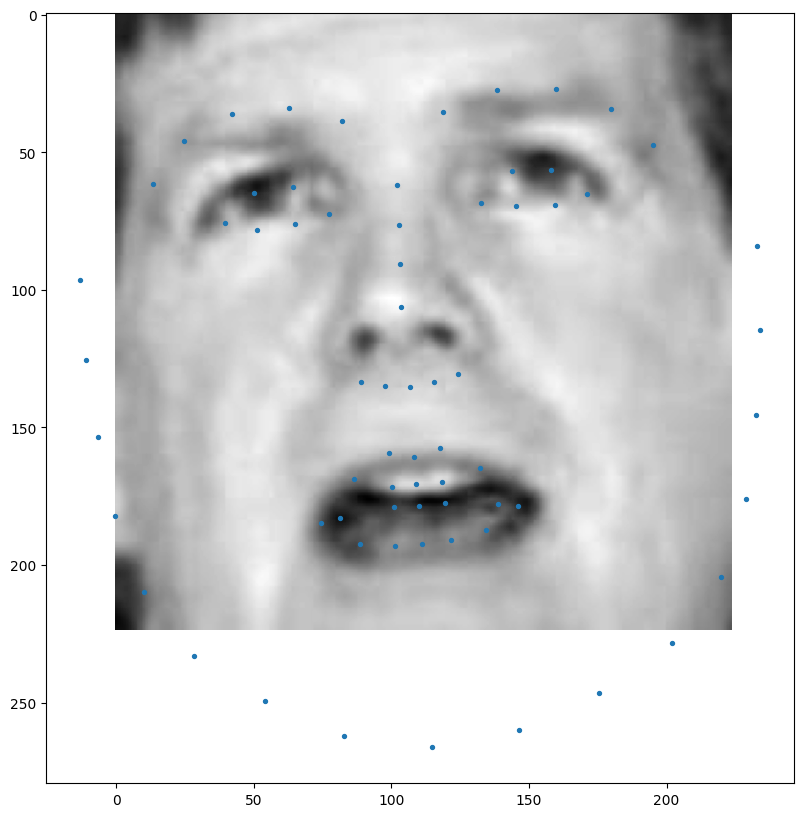

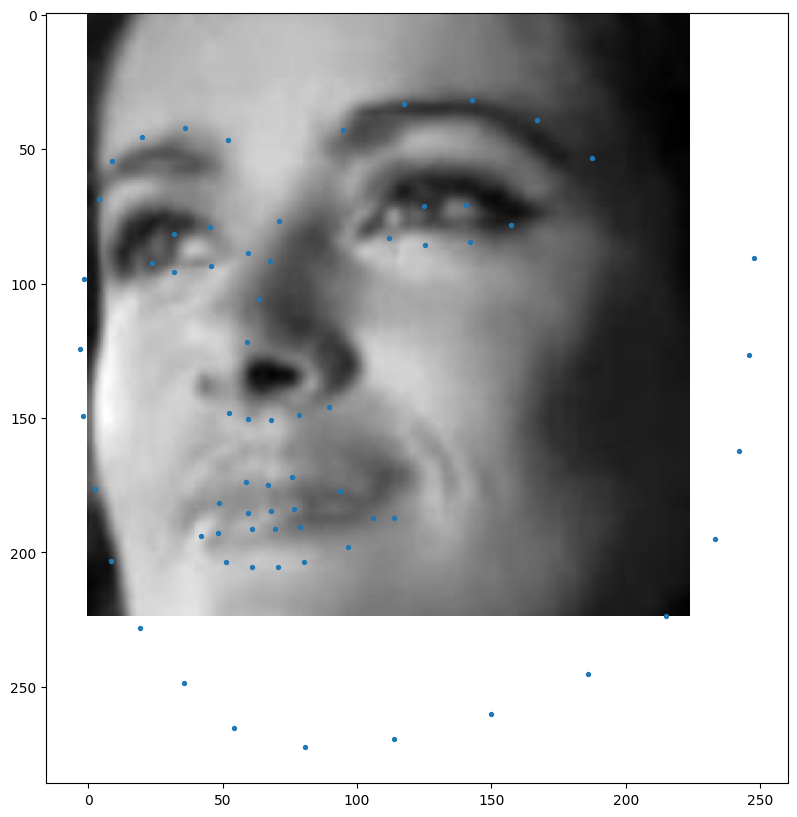

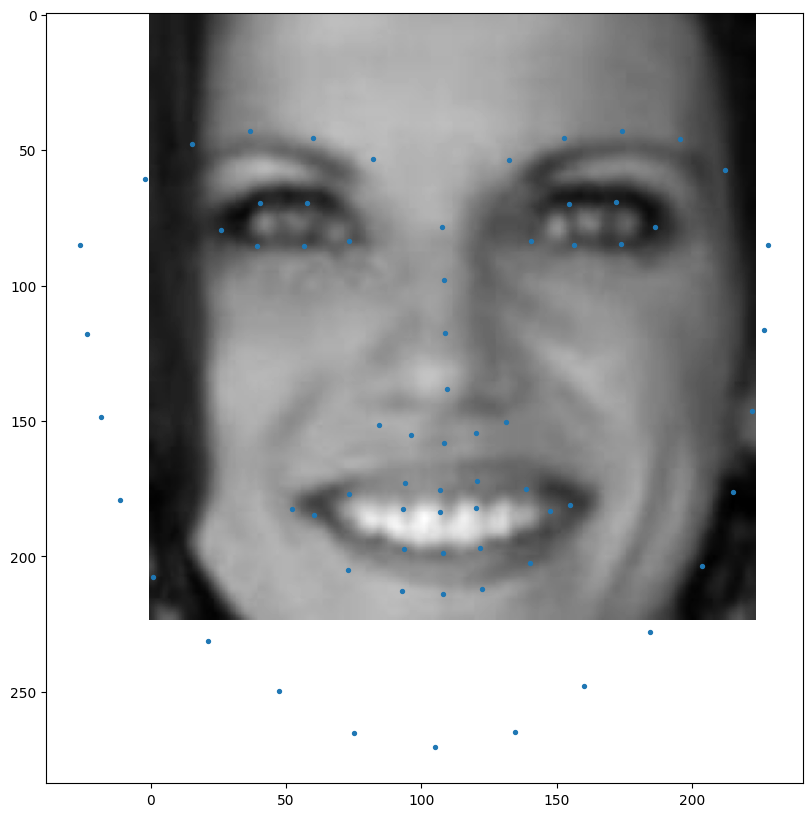

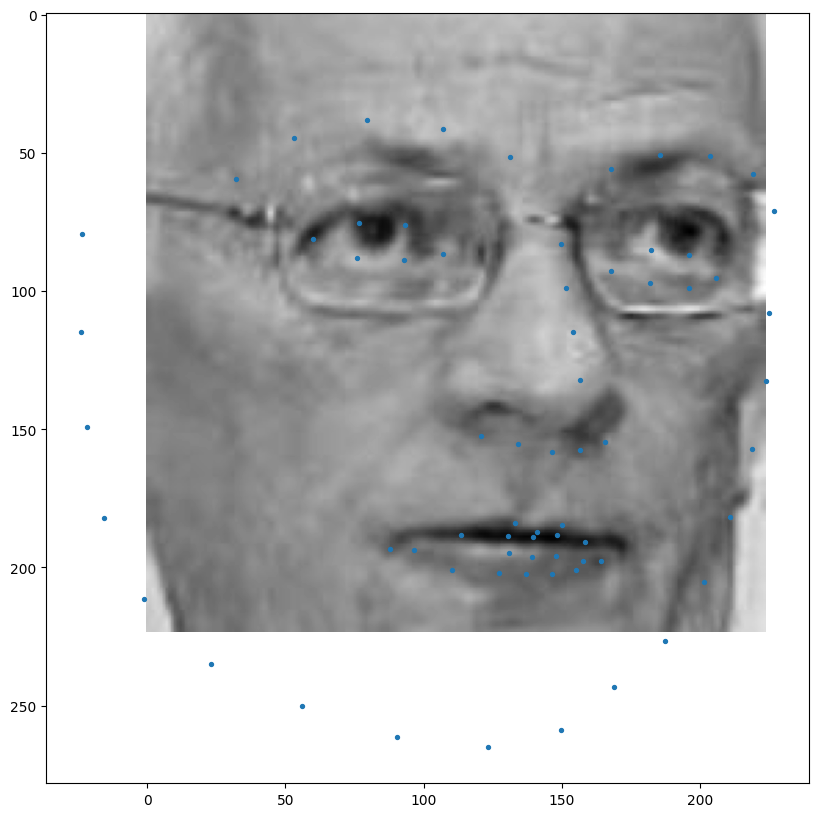

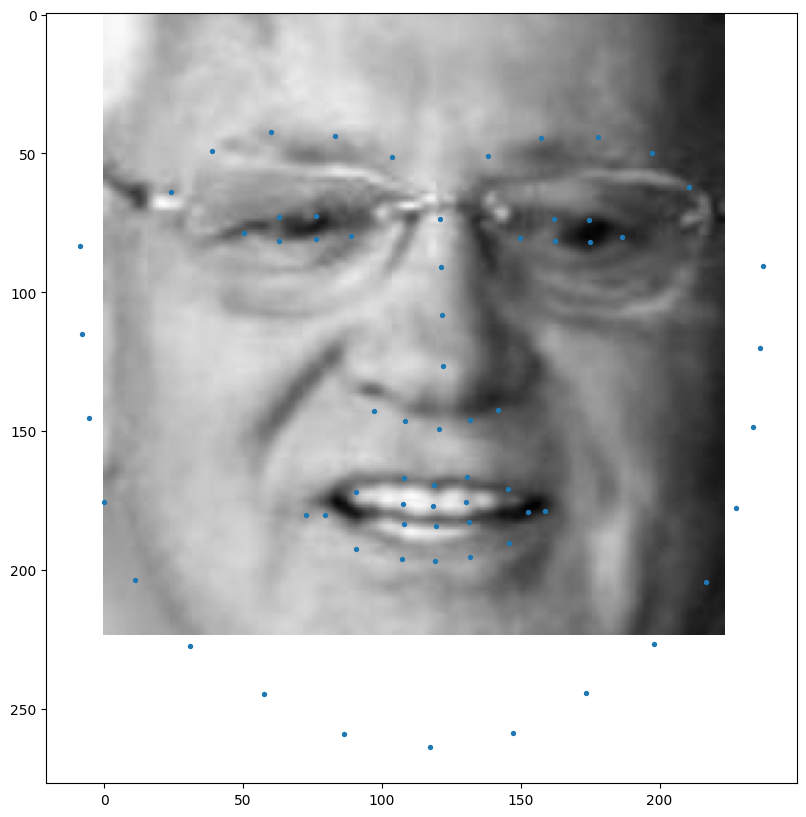

In [23]:

model_XceptionNet.to(device)

model_XceptionNet.eval()

for i, (features, _) in enumerate(detected_test_loader):
    if i >= 5:
        break
    features = features.to(device)
    outputs = model_XceptionNet(features)
    features = features.cpu().detach()  
    outputs = outputs.cpu().detach()
    outputs = outputs.view(outputs.size(0), 68, 2)
    visualize_landmarks(features[0], outputs[0])

## Trying to build model which process facial nodes into embedings.
#### Spoiler it was useless))

In [27]:
class TripletFaceDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = os.listdir(root_dir)
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}
        self.idx_to_class = {idx: cls_name for cls_name, idx in self.class_to_idx.items()}
        self.image_paths = {}
        
        for class_ in self.classes:
            class_dir = os.path.join(root_dir, class_)
            if os.path.isdir(class_dir):
                self.image_paths[class_] = [os.path.join(class_dir, img) for img in os.listdir(class_dir)]
        
        self.triplets = self.generate_triplets()

    def generate_triplets(self):
        triplets = []
        for class_ in self.image_paths:
            positive_images = self.image_paths[class_]

            other_classes = list(self.image_paths.keys())
            other_classes.remove(class_)
            
            for anchor_image in positive_images:
                positive_image = random.choice([img for img in positive_images if img != anchor_image])
                negative_class = random.choice(other_classes)
                negative_image = random.choice(self.image_paths[negative_class])
                
                triplets.append((anchor_image, positive_image, negative_image))
        
        return triplets

    def __len__(self):
        return len(self.triplets)
    
    def __getitem__(self, idx):
        anchor_path, positive_path, negative_path = self.triplets[idx]
        
        anchor_image = Image.open(anchor_path).convert('RGB')
        positive_image = Image.open(positive_path).convert('RGB')
        negative_image = Image.open(negative_path).convert('RGB')
        
        if self.transform:
            anchor_image = self.transform(anchor_image)
            positive_image = self.transform(positive_image)
            negative_image = self.transform(negative_image)
        
        return anchor_image, positive_image, negative_image

    def get_class_name(self, class_idx):
        return self.idx_to_class[class_idx]




transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=1), 
    transforms.ToTensor(),
])

dataset = TripletFaceDataset(root_dir='Detected_faces', transform=transform)

val_size = int(0.1 * len(dataset))  
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])

batch_size = 8
if device == torch.device("cuda"):
    train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_ds, batch_size, num_workers=4)
else:
    train_loader = DataLoader(train_ds, batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size)

In [28]:
class FaceRecognitiondNet(nn.Module):
    def __init__(self, output_dim):
        super(FaceRecognitiondNet, self).__init__()
        self.align = model_XceptionNet
        for param in self.align.parameters():
            param.requires_grad = False
        self.fc1 = nn.Linear(136, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, output_dim)

    def forward(self, image):
        x = self.align(image)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [29]:
output_dim = 128

face_rec_model = FaceRecognitiondNet(output_dim)
face_rec_model.to(device)

class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin
        self.loss_fn = nn.TripletMarginLoss(margin=margin, p=2)

    def forward(self, anchor, positive, negative):
        return self.loss_fn(anchor, positive, negative)
    
def compute_id_rate(anchor_out, positive_out, negative_out):
    pos_dist = torch.norm(anchor_out - positive_out, dim=1)
    neg_dist = torch.norm(anchor_out - negative_out, dim=1)
    correct = (pos_dist < neg_dist).sum().item()
    total = anchor_out.size(0)
    return correct / total

triplet_loss = TripletLoss(margin=1.0)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, face_rec_model.parameters()), lr=0.001)

epochs = 20
best_loss = np.inf

In [ ]:
for epoch in range(epochs):
    face_rec_model.train()
    train_loss = 0.0
    train_id_rate = 0.0
    for batch in tqdm((train_loader)):
        anchor, positive, negative = batch
        optimizer.zero_grad()

        anchor = anchor.to(device)
        positive = positive.to(device)
        negative = negative.to(device)

        anchor_out = face_rec_model(anchor)
        positive_out = face_rec_model(positive)
        negative_out = face_rec_model(negative)

        loss = triplet_loss(anchor_out, positive_out, negative_out)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_id_rate += compute_id_rate(anchor_out, positive_out, negative_out)

        if device == "mps":
            torch.mps.empty_cache()
        elif device == "cuda":
            torch.cuda.empty_cache()
    
    train_loss /= len(train_loader)
    train_id_rate /= len(train_loader)

    face_rec_model.eval()
    val_loss = 0.0
    val_id_rate = 0.0
    with torch.no_grad():
        for batch in tqdm((val_loader)):
            anchor, positive, negative = batch
            
            anchor = anchor.to(device)
            positive = positive.to(device)
            negative = negative.to(device)

            anchor_out = face_rec_model(anchor)
            positive_out = face_rec_model(positive)
            negative_out = face_rec_model(negative)

            loss = triplet_loss(anchor_out, positive_out, negative_out)
            val_loss += loss.item()
            val_id_rate += compute_id_rate(anchor_out, positive_out, negative_out)

            if device == "mps":
                torch.mps.empty_cache()
            elif device == "cuda":
                torch.cuda.empty_cache()

    val_loss /= len(val_loader)
    val_id_rate /= len(val_loader)
    
    if val_loss < best_loss:
        best_loss = val_loss
        print('Saving face_rec_model....................')
        torch.save(face_rec_model.state_dict(), 'face_rec_model.pt')
    
    print(f"Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Train ID Rate: {train_id_rate:.4f}, Val Loss: {val_loss:.4f}, Val ID Rate: {val_id_rate:.4f}")

In [60]:
face_rec_model.load_state_dict(torch.load('face_rec_model.pt', map_location = 'cpu'))

<All keys matched successfully>

#### Thats what I get, I dont know.... It was even hard to fit the model into GPU on Kaggle. You should froze almost every weights

In [61]:
def rank1_identification_rate(embeddings, labels):
    correct = 0
    for i, embedding in enumerate(embeddings):
        distances = np.linalg.norm(embeddings - embedding, axis=1)
        indices = np.argsort(distances)
        if labels[i] == labels[indices[1]]:
            correct += 1
    return correct / len(embeddings)

def get_embeddings_and_labels(model, dataloader, device):
    model.eval()
    embeddings = []
    labels = []
    with torch.no_grad():
        for images, target in tqdm(dataloader):
            images = images.to(device)
            output = model(images)
            embeddings.append(output.cpu())
            labels.append(target.cpu())
    embeddings = torch.cat(embeddings).numpy()
    labels = torch.cat(labels).numpy()
    return embeddings, labels

embeddings, labels = get_embeddings_and_labels(face_rec_model, detected_test_loader, device)

rank1_rate = rank1_identification_rate(embeddings, labels)
print(f'Rank-1 Identification Rate: {rank1_rate * 100:.2f}%')

100%|██████████| 573/573 [02:01<00:00,  4.70it/s]


Rank-1 Identification Rate: 2.34%


In [35]:
from sklearn import svm
from sklearn.metrics import accuracy_score

In [36]:
def get_embeddings_and_labels(model, loader, device, dataset):
    model.eval()
    embeddings = []
    labels = []
    with torch.no_grad():
        for batch in tqdm(loader):
            anchors, positives, negatives = batch
            anchors = anchors.to(device)
            positives = positives.to(device)
            negatives = negatives.to(device)
            
            anchor_embeddings = model(anchors)
            positive_embeddings = model(positives)
            negative_embeddings = model(negatives)
            
            embeddings.extend(anchor_embeddings.cpu().numpy())
            labels.extend([dataset.class_to_idx[os.path.basename(os.path.dirname(dataset.triplets[idx][0]))] for idx in range(len(anchors))])
            embeddings.extend(positive_embeddings.cpu().numpy())
            labels.extend([dataset.class_to_idx[os.path.basename(os.path.dirname(dataset.triplets[idx][1]))] for idx in range(len(positives))])
            embeddings.extend(negative_embeddings.cpu().numpy())
            labels.extend([dataset.class_to_idx[os.path.basename(os.path.dirname(dataset.triplets[idx][2]))] for idx in range(len(negatives))])
    return np.array(embeddings), np.array(labels)



train_embeddings, train_labels = get_embeddings_and_labels(face_rec_model, train_loader, device, dataset)
val_embeddings, val_labels = get_embeddings_and_labels(face_rec_model, val_loader, device, dataset)

svm_model = svm.SVC(kernel='linear')
svm_model.fit(train_embeddings, train_labels)

val_predictions = svm_model.predict(val_embeddings)
accuracy = accuracy_score(val_labels, val_predictions)
print(f'Validation Accuracy: {accuracy:.4f}')


100%|██████████| 115/115 [00:34<00:00,  3.29it/s]


Validation Accuracy: 0.4163


#### As we can see destribution also not so great. I'm not sure whats the problem, maybe it's the Xception NN, maybe data, maybe something else, but I have tried. 

100%|██████████| 573/573 [01:50<00:00,  5.16it/s]


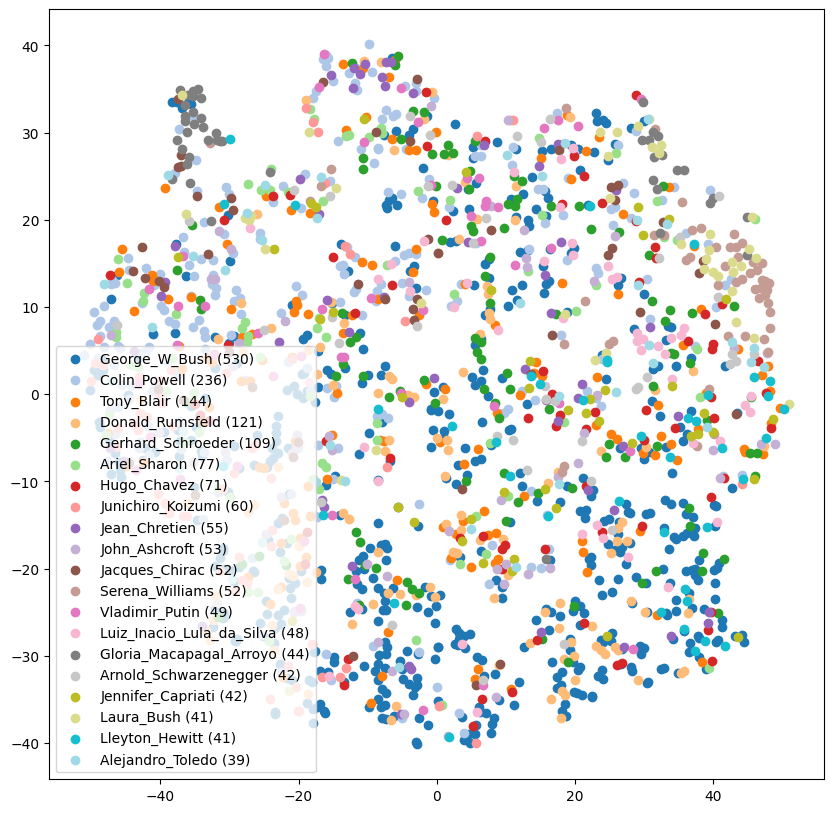

In [56]:
from sklearn.manifold import TSNE
from tqdm import tqdm
from collections import Counter

def visualize_embeddings(model, dataloader, device, class_to_idx, top_k=20):
    model.eval()
    embeddings = []
    labels = []
    with torch.no_grad():
        for data, target in tqdm(dataloader):
            data = data.to(device)
            output = model(data)
            embeddings.append(output.cpu())
            labels.append(target.cpu())
    embeddings = torch.cat(embeddings)
    labels = torch.cat(labels)

    label_counts = Counter(labels.numpy())

    top_k_classes = [label for label, count in label_counts.most_common(top_k)]
    top_k_mask = np.isin(labels.numpy(), top_k_classes)
    
    embeddings = embeddings[top_k_mask]
    labels = labels[top_k_mask]

    tsne = TSNE(n_components=2, random_state=42)
    reduced_embeddings = tsne.fit_transform(embeddings)

    plt.figure(figsize=(10, 10))
    num_classes = len(top_k_classes)
    colors = plt.cm.tab20(np.linspace(0, 1, num_classes))

    idx_to_class = {v: k for k, v in class_to_idx.items()}

    for i, label in enumerate(top_k_classes):
        label_mask = labels == label
        plt.scatter(reduced_embeddings[label_mask, 0], reduced_embeddings[label_mask, 1],
                    color=colors[i], label=f"{idx_to_class[label]} ({label_counts[label]})")

    plt.legend()
    plt.show()

class_to_idx = detected_test_dataset.get_class_to_idx()

visualize_embeddings(face_rec_model, detected_test_loader, device, class_to_idx, top_k=20)

#### And as you can see, inference also sucks.....

100%|██████████| 573/573 [01:56<00:00,  4.91it/s]


Target Image: Detected_faces/John_McCallum/John_McCallum_0001.jpg
Similar Images: ['Detected_faces/Phil_Mickelson/Phil_Mickelson_0002.jpg', 'Detected_faces/Paul_McNulty/Paul_McNulty_0002.jpg']


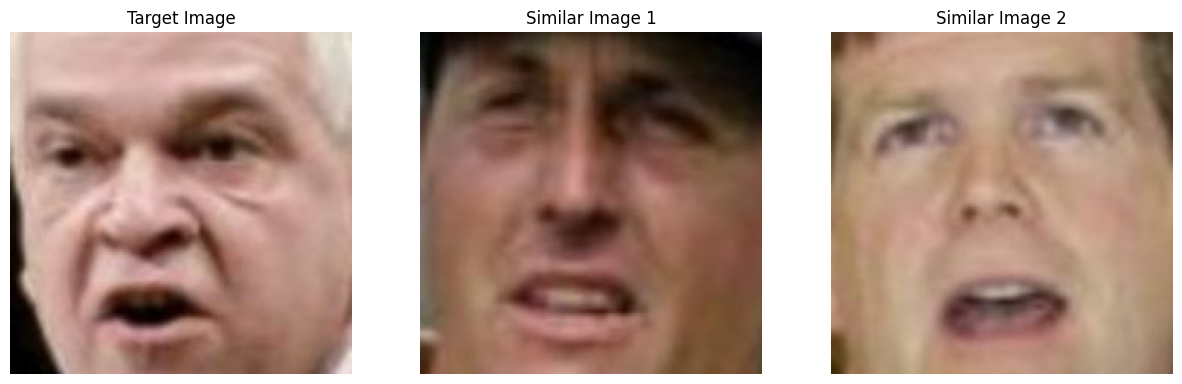

In [62]:
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity

def find_most_similar_images_with_names(model, dataloader, device, dataset, n=3):
    model.eval()
    embeddings = []
    image_paths = []
    labels = []
    
    with torch.no_grad():
        for data, target in tqdm(dataloader):
            data = data.to(device)
            output = model(data)
            embeddings.append(output.cpu())
            labels.append(target.cpu())
            image_paths.extend([dataset.get_path(i) for i in range(len(data))])
    
    embeddings = torch.cat(embeddings).numpy()
    labels = torch.cat(labels).numpy()

    similarity_matrix = cosine_similarity(embeddings, embeddings)

    def get_similar_images(index):
        similarities = similarity_matrix[index]

        sorted_indices = np.argsort(-similarities)

        similar_images = [image_paths[i] for i in sorted_indices[1:n+1]]
        similar_labels = [labels[i] for i in sorted_indices[1:n+1]]

        return similar_images, similar_labels

    return get_similar_images

get_similar_images = find_most_similar_images_with_names(face_rec_model, detected_test_loader, device, detected_test_dataset, n=2)

index = np.random.randint(len(detected_test_loader.dataset))
similar_images, similar_labels = get_similar_images(index)

print(f'Target Image: {detected_test_dataset.get_path(index)}')
print(f'Similar Images: {similar_images}')

plt.figure(figsize=(15, 5))
target_image = Image.open(detected_test_dataset.get_path(index)).convert('RGB')
plt.subplot(1, len(similar_images) + 1, 1)
plt.imshow(target_image)
plt.title('Target Image')
plt.axis('off')

for i, img_path in enumerate(similar_images):
    similar_image = Image.open(img_path).convert('RGB')
    plt.subplot(1, len(similar_images) + 1, i + 2)
    plt.imshow(similar_image)
    plt.title(f'Similar Image {i + 1}')
    plt.axis('off')

plt.show()


##### In general, I use only pre-trained models and libraries such as deep face, it would be possible to achieve good results, but I did not make a comparison because the model simply did not learn and it did not make much sense. I really hope for feedback and comments on the work in the style that could be done

###### Очень надеюсь на фидбэк и комменты к работе в стиле, что можно было бы сделать, можно на русском